## Assignment 10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from albumentations.pytorch import ToTensorV2

from app.models.resnet import ResNet
from app.utils.lr_finder import LRFinder
from app.utils.transforms import transforms
from app.explainability.gradcam import GradCAM
from app.utils.misc import set_seed, tensor_to_image
from app.datasets.tinyimagenet import load_tinyimagenet
from app.utils.train_test_loops import train_loop, test_loop
from app.utils.result_stats import loss_acc_curves, score_report
from app.utils.result_analysis import (
    get_misclassified_info,
    visualize_misclassified_images,
    misclassified_gradcam
)

from app.utils.lr_finder import LRFinder

from app.utils.dataset import (
    calc_data_stats,
    visualise_transforms,
    class_to_idx,
    idx_to_class,
)

import matplotlib.pyplot as plt

set_seed(69)

In [2]:
################################
## CONFIG
################################

DATASET_NAME = "tiny-imagenet"
DATASET_PATH = f"./../data/{DATASET_NAME}/"
NUM_CLASSES = 200
NUM_INPUT_CHANNELS = 3

BATCH_SIZE = 256
EPOCHS = 1
LEARNING_RATE = 1e-7

# SET GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nWe're using =>", device)


We're using => cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

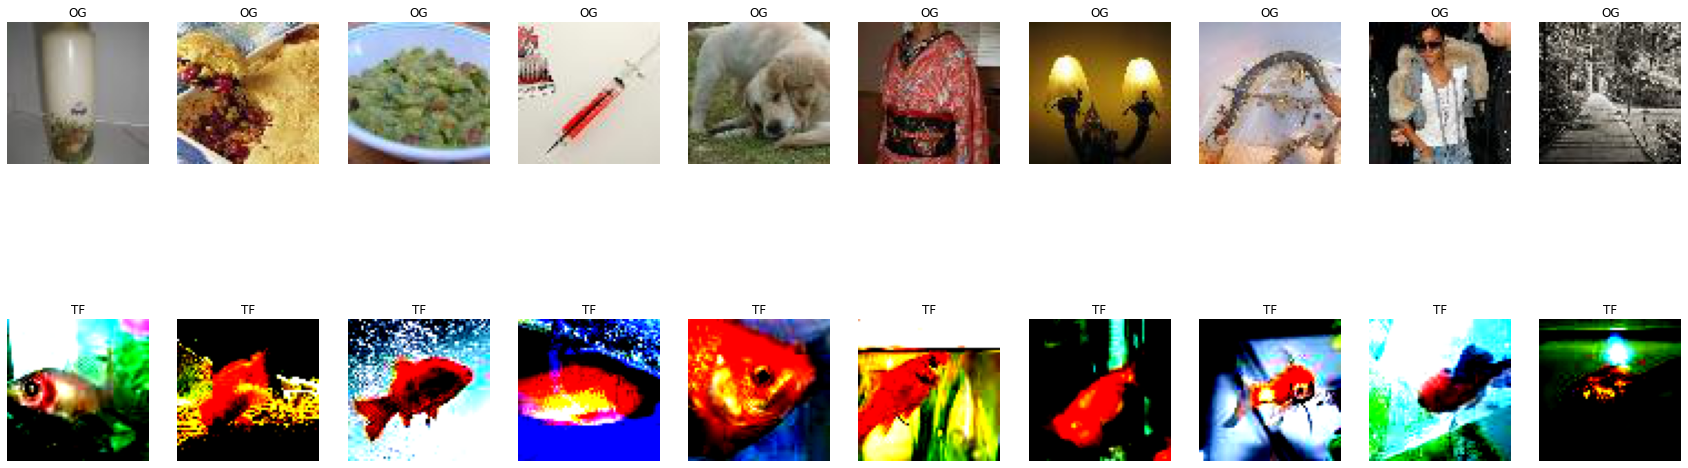

In [3]:
################################
## LOAD DATASET
################################

# datasets
og_dataset = load_tinyimagenet(
    dataset_path=DATASET_PATH, is_train=False, image_transforms=ToTensorV2(),
)

# calculate dataset mean and std
dataset_mean, dataset_std = calc_data_stats(og_dataset)

image_transforms = transforms(dataset_mean, dataset_std)

train_dataset = load_tinyimagenet(
    dataset_path=DATASET_PATH,
    is_train=True,
    image_transforms=image_transforms["train"],
)

test_dataset = load_tinyimagenet(
    dataset_path=DATASET_PATH,
    is_train=False,
    image_transforms=image_transforms["test"],
)


class2idx = class_to_idx(og_dataset.classes)
idx2class = idx_to_class(class2idx)


visualise_transforms(
    original_data=og_dataset, transformed_data=train_dataset, num_samples=10
)

In [4]:
################################
## CREATE DATALOADERS
################################

# dataloader
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE)

val_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE)

test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE)

## Data Sanity Check
print(f"\nTrain loader = {next(iter(train_loader))[0].shape}")
print(f"Val loader = {next(iter(val_loader))[0].shape}")
print(f"Test loader = {next(iter(test_loader))[0].shape}")
print(f"\nTrain loader length = {len(train_loader)}")
print(f"Val loader length = {len(val_loader)}")
print(f"Test loader length = {len(test_loader)}")


Train loader = torch.Size([256, 3, 64, 64])
Val loader = torch.Size([256, 3, 64, 64])
Test loader = torch.Size([256, 3, 64, 64])

Train loader length = 391
Val loader length = 391
Test loader length = 40


In [5]:
################################
## LOAD MODEL
################################

model = ResNet(num_input_channels=NUM_INPUT_CHANNELS, num_classes=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.99)

0it [00:00, ?it/s]

Recommended LR = 1.1797632721724125e-07 at loss=5.394237347222768


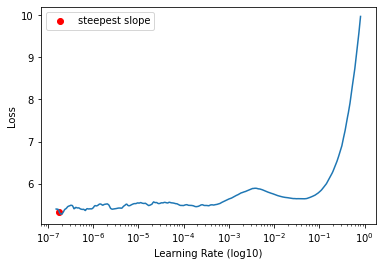

In [6]:
lr_finder = LRFinder(model=model, criterion=criterion, optimizer=optimizer, device=device)
LEARNING_RATE = lr_finder.run(dataloader=train_loader)
lr_finder.plot()

In [7]:
LEARNING_RATE = 0.001

In [8]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=round(LEARNING_RATE, 3), 
                                          steps_per_epoch=len(train_loader), 
                                          epochs=EPOCHS)

In [9]:
###########################
## Train Loop
################################
trained_model, loss_stats, acc_stats = train_loop(
    model=model,
    epochs=EPOCHS,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)


loss_acc_curves(loss_stats=loss_stats, acc_stats=acc_stats)


Begin training.


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
################################
## Test Loop
################################
y_pred_list, y_true_list = test_loop(
    model=trained_model, test_loader=test_loader, device=device,
)

In [ ]:
################################
## Result Stats
################################
print(score_report(y_true_list, y_pred_list, idx2class))

In [ ]:
################################
## Result Analysis
################################

def get_misclassified_info(y_pred_list, y_true_list):
    return [
        {"idx": i, "pred": pred, "true": actual}
        for i, (pred, actual) in enumerate(zip(y_pred_list, y_true_list))
        if pred != actual
    ]


misclassified_info = get_misclassified_info(
    y_pred_list=y_pred_list, y_true_list=y_true_list
)


visualize_misclassified_images(
    misclassified_info=misclassified_info,
    dataset=og_dataset,
    idx_to_class=idx2class,
    num_samples=11,
)

In [ ]:
################################
## GradCAM
################################
x_test, y_test = test_dataset[40]


tensor_to_image(x_test)

In [ ]:
cam = GradCAM(
    model=trained_model, target_layer=trained_model.layer_2.base_layer[-1].base_block[-1][0]
)

output = cam(x_test.to(device))


plt.imshow(output)

In [ ]:
misclassified_gradcam(
    model = trained_model,
    misclassified_info=misclassified_info,
    dataset=test_dataset,
    idx_to_class=idx2class,
    num_samples=10,
    device=device
)